## Initial Data Cleaning ##

Collects and unifies primary and secondary school data where the anonymized student is present in both.

In [16]:
import csv
import os
import pandas as pd
import numpy as np
import seaborn as sns

In [17]:
# Check files in the Raw Data folder
os.listdir('../Data/Raw')

['Avaluació_de_quart_d’Educació_Secundària_Obligatòria_20260210.csv',
 "Avaluació_de_sisè_d'educació_primària_20260210.csv"]

In [ ]:
# Take the first file in the Raw Data folder
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[0])

secondary_data = []
with open(csv_path) as data: 
    reader = csv.reader(data)
    for row in reader:
        secondary_data.append(row)
    data.close()
df_S = pd.DataFrame(secondary_data)

# Second file in the Raw Data folder
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[1])
primary_data = []
with open(csv_path) as data: 
    reader = csv.reader(data)
    for row in reader:
        primary_data.append(row)
    data.close()
df_P = pd.DataFrame(primary_data)

In [19]:
df_P.columns = df_P.iloc[0]    # set first row as header
df_P = df_P[1:]                # drop the first row (since it's now the header)
df_P.reset_index(drop=True, inplace=True)

df_S.columns = df_S.iloc[0]    # set first row as header
df_S = df_S[1:]                # drop the first row (since it's now the header)
df_S.reset_index(drop=True, inplace=True)

In [20]:
df = pd.DataFrame({'CODI_ALUMNE': pd.concat([df_P['CODI_ALUMNE'], df_S['CODI_ALUMNE']]).unique()})
df['in_P'] = df['CODI_ALUMNE'].isin(df_P['CODI_ALUMNE']) 
df['in_S'] = df['CODI_ALUMNE'].isin(df_S['CODI_ALUMNE'])
matching = df[df['in_P'] & df['in_S']] 

# Keep only rows from df_P where CODI_ALUMNE exists in both
df_P_matching = df_P[df_P['CODI_ALUMNE'].isin(matching['CODI_ALUMNE'])].copy()
# Keep only rows from df_S where CODI_ALUMNE exists in both
df_S_matching = df_S[df_S['CODI_ALUMNE'].isin(matching['CODI_ALUMNE'])].copy()

df_P_matching.reset_index(drop=True, inplace=True)
df_S_matching.reset_index(drop=True, inplace=True)

In [21]:
common_cols = set(df_P_matching.columns) & set(df_S_matching.columns)

In [22]:
print(df_P.columns)
print(df_S.columns)

Index(['ANY', 'CODI_ALUMNE', 'PCAT', 'PCAT_CL', 'PCAT_EE', 'PCAST', 'PCAST_CL',
       'PCAST_EE', 'PMAT', 'PMAT_NC', 'PMAT_EFM', 'PMAT_CR', 'PANG', 'PANG_CO',
       'PANG_CE', 'PFRAN', 'PFRAN_CO', 'PFRAN_CE', 'PANG_EE', 'PFRAN_EE',
       'PCAT_CO', 'PCAST_CO', 'PMED', 'PMED_COMP1', 'PMED_COMP2', 'PMED_COMP3',
       'GENERE', 'MES_NAIXEMENT', 'ANY_NAIXEMENT', 'AREA_TERRITORIAL',
       'NATURALESA', 'HÃ€BITAT'],
      dtype='object', name=0)
Index(['ANY', 'CODI_ALUMNE', 'PCAT', 'PCAT_CL', 'PCAT_EE', 'PCAST', 'PCAST_CL',
       'PCAST_EE', 'PANG', 'PANG_CO', 'PANG_CL', 'PANG_EE', 'PFRAN',
       'PFRAN_CO', 'PFRAN_CL', 'PFRAN_EE', 'PMAT', 'PMAT_EFM', 'PMAT_CR',
       'PMAT_EST', 'PMAT_NC', 'PALE', 'PALE_CO', 'PALE_CL', 'PALE_EE', 'PCIEN',
       'PCIEN_COMP1', 'PCIEN_COMP2', 'PCIEN_COMP3', 'PCIEN_COMP4', 'GENERE',
       'MES_NAIXEMENT', 'ANY_NAIXEMENT', 'NATURALESA', 'Ã€REA TERRITORIAL',
       'HÃ€BITAT'],
      dtype='object', name=0)


In [23]:
# List of required columns
required_cols = [
    'ANY', 'ANY_NAIXEMENT', 'CODI_ALUMNE', 'GENERE', 'HÃ€BITAT',
    'MES_NAIXEMENT', 'NATURALESA', 'PANG', 'PANG_CO', 'PANG_EE',
    'PCAST', 'PCAST_CL', 'PCAST_EE', 'PCAT', 'PCAT_CL', 'PCAT_EE',
    'PFRAN', 'PFRAN_CO', 'PFRAN_EE', 'PMAT', 'PMAT_CR', 'PMAT_EFM', 'PMAT_NC'
]

df_P_clean = df_P.dropna(subset=required_cols).copy()
df_S_clean = df_S.dropna(subset=required_cols).copy()

common_ids = set(df_P_clean['CODI_ALUMNE']) & set(df_S_clean['CODI_ALUMNE'])
df_P_clean = df_P_clean[df_P_clean['CODI_ALUMNE'].isin(common_ids)]
df_S_clean = df_S_clean[df_S_clean['CODI_ALUMNE'].isin(common_ids)]

df_P_clean['snapshot'] = 'past'
df_S_clean['snapshot'] = 'present'

df_combined = pd.concat([df_P_clean, df_S_clean], ignore_index=True)

df_pivot = df_combined.pivot_table(
    index='CODI_ALUMNE',
    columns='snapshot',
    values=[col for col in required_cols if col != 'CODI_ALUMNE'],
    aggfunc='first'
)

In [24]:
df_pivot

0             ANY         ANY_NAIXEMENT         GENERE          \
snapshot     past present          past present   past present   
CODI_ALUMNE                                                      
             2018    2019          2005              H       D   
100028145    2018    2022          2005    2005      D       D   
1000332771   2016    2020          2004    2004      H       H   
1000343103   2016    2020          2004    2004      D       D   
1000354325   2016    2020          2004    2004      D       D   
...           ...     ...           ...     ...    ...     ...   
999005478    2016    2020          2004    2004      H       H   
999027032    2016    2020          2004    2004      H       H   
99949376     2016    2020          2004    2004      D       D   
99961597     2019    2023          2007    2007      H       H   
99983150     2018    2022          2006    2006      D       D   

0                     HÃ€BITAT                    MES_NAIXEMENT          ...  \
snapshot                  past            present          past present  ...   
CODI_ALUMNE                                                              ...   
                MÃ©s de 100000     MÃ©s de 100000             1          ...   
100028145       MÃ©s de 100000     MÃ©s de 100000             7       7  ...   
1000332771   De 10001 a 100000  De 10001 a 100000             1       1  ...   
1000343103   De 10001 a 100000  De 10001 a 100000             1       1  ...   
1000354325   De 10001 a 100000  De 10001 a 100000            10      10  ...   
...                        ...                ...           ...     ...  ...   
999005478    De 10001 a 100000  De 10001 a 100000            11      11  ...   
999027032    De 10001 a 100000  De 10001 a 100000             9       9  ...   
99949376        MÃ©s de 100000     MÃ©s de 100000             7       7  ...   
99961597        MÃ©s de 100000     MÃ©s de 100000             7       7  ...   
99983150        MÃ©s de 100000     MÃ©s de 100000            10      10  ...   

0           PFRAN_EE           PMAT         PMAT_CR         PMAT_EFM          \
snapshot        past present   past present    past present     past present   
CODI_ALUMNE                                                                    
                              91,49          100,00            81,82           
100028145                     76,89   43,33   88,89   66,67    81,82   33,33   
1000332771                    91,59    79,8  100,00   88,89    91,67      70   
1000343103                    97,28   74,88  100,00   77,78   100,00      90   
1000354325                    94,20    97,5  100,00     100    83,43      90   
...              ...     ...    ...     ...     ...     ...      ...     ...   
999005478                     82,39   45,08   88,49   22,22    75,34      20   
999027032                     82,84   59,48   88,49   66,67    91,43      30   
99949376                      97,09   82,82  100,00   88,89    91,67      90   
99961597                      81,57   70,86   77,78    87,5    81,82    62,5   
99983150                      90,79   49,17   88,89   33,33    90,91   33,33   

0           PMAT_NC          
snapshot       past present  
CODI_ALUMNE                  
              92,86          
100028145     57,14       0  
1000332771    84,30   71,43  
1000343103    92,22   42,86  
1000354325   100,00     100  
...             ...     ...  
999005478     84,23   71,43  
999027032     69,41   85,71  
99949376     100,00   85,71  
99961597      85,71   55,56  
99983150      92,86    62,5  

[251748 rows x 44 columns]

In [25]:
df_pivot.shape[0]

251748

In [26]:
matching.shape[0]

251748

In [27]:
common_cols

{'ANY',
 'ANY_NAIXEMENT',
 'CODI_ALUMNE',
 'GENERE',
 'HÃ€BITAT',
 'MES_NAIXEMENT',
 'NATURALESA',
 'PANG',
 'PANG_CO',
 'PANG_EE',
 'PCAST',
 'PCAST_CL',
 'PCAST_EE',
 'PCAT',
 'PCAT_CL',
 'PCAT_EE',
 'PFRAN',
 'PFRAN_CO',
 'PFRAN_EE',
 'PMAT',
 'PMAT_CR',
 'PMAT_EFM',
 'PMAT_NC'}

In [28]:
# One-to-one merge by CODI_ALUMNE eliminating duplicates

print("df_P_matching: files =", len(df_P_matching),
      " unique students =", df_P_matching['CODI_ALUMNE'].nunique())

print("df_S_matching: files =", len(df_S_matching),
      " unique students =", df_S_matching['CODI_ALUMNE'].nunique())

df_P_unique = df_P_matching.sort_values('CODI_ALUMNE').drop_duplicates('CODI_ALUMNE')
df_S_unique = df_S_matching.sort_values('CODI_ALUMNE').drop_duplicates('CODI_ALUMNE')

df_merged = pd.merge(
    df_P_unique,
    df_S_unique,
    on='CODI_ALUMNE',
    how='inner',           # only keep rows present in both
    suffixes=('_P', '_S'), # distinguish the two sets of columns
    validate='one_to_one'
)

df_P_matching: files = 700990  unique students = 251748
df_S_matching: files = 489510  unique students = 251748


In [29]:
# ===============================
# 1. Helper: convert grade columns to numeric (comma → dot)
# ===============================
def convert_grade_columns_to_numeric(df, prefix="P"):
    """
    Convert all columns starting with a given prefix (e.g. 'P')
    from strings with comma decimals to numeric floats.
    Non-convertible values become NaN.
    """
    grade_cols = [c for c in df.columns if c.startswith(prefix)]
    for col in grade_cols:
        # Ensure string type first
        s = df[col].astype(str)
        # Replace comma with dot for decimal conversion
        s = s.str.replace(",", ".", regex=False)
        # Convert to numeric
        df[col] = pd.to_numeric(s, errors="coerce")
    return grade_cols  

# ===============================
# 2. Convert grade columns in Primary (P) and Secondary (S)
# ===============================
grade_cols_P = convert_grade_columns_to_numeric(df_P_unique, prefix="P")
grade_cols_S = convert_grade_columns_to_numeric(df_S_unique, prefix="P")

grade_cols_P = ['PCAT', 'PCAST', 'PMAT', 'PANG', 'PMED']
grade_cols_S = ['PCAT', 'PCAST', 'PMAT', 'PANG', 'PCIEN']

# Choose the Mathematics column name (assumes 'PMAT' exists in both)
math_col_name = "PMAT"

# Columns for correlation (all grades except Mathematics)
other_P = [c for c in grade_cols_P if c != math_col_name]
other_S = [c for c in grade_cols_S if c != math_col_name]

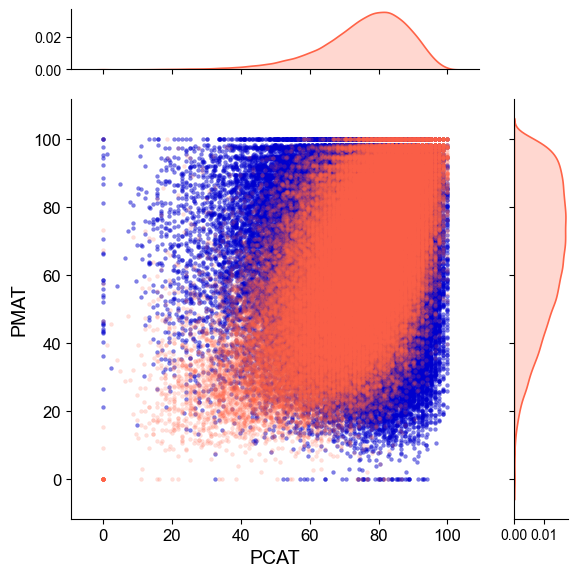

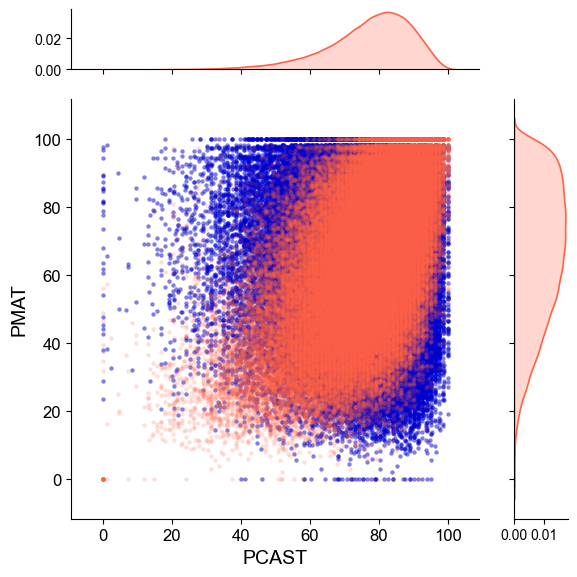

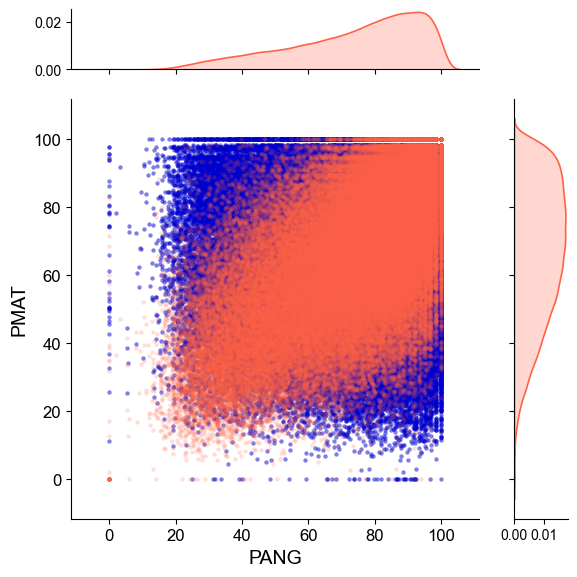

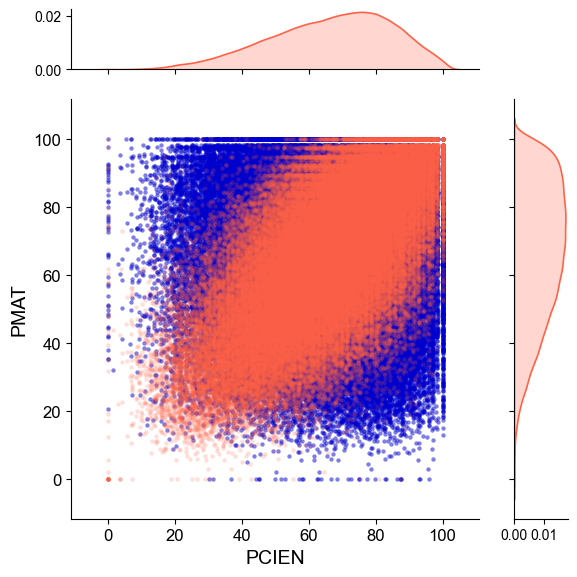

In [30]:
# ---------------- Secondary Original & Shuffled together ----------------------------------

max_points = 100000

# Plotting style --------
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 14,          # mida general
    'axes.titlesize': 16,     # títol
    'axes.labelsize': 14,     # noms dels eixos
    'xtick.labelsize': 12,    # ticks
    'ytick.labelsize': 12,
    'legend.fontsize': 12,    # llegenda
    'font.family': 'Arial'

})

# Sample to avoid plotting an enormous dataset
if len(df_S_unique) > max_points:
    df_S_plot = df_S_unique.sample(n=max_points, random_state=0)
else:
    df_S_plot = df_S_unique

# Loop over all subjects except target
for col in other_S:
    # Skip columns that are completely NaN or identical to math column
    if col == math_col_name:
        continue
    if df_S_plot[col].dropna().empty:
        continue

    x = df_S_plot[col].values
    y = df_S_plot[math_col_name].values

    # 1. Convert everything properly
    x = df_S_plot[col].astype(str).str.replace(",", ".", regex=False)
    y = df_S_plot[math_col_name].astype(str).str.replace(",", ".", regex=False)

    # Convert to numeric
    x = pd.to_numeric(x, errors="coerce").to_numpy()
    y = pd.to_numeric(y, errors="coerce").to_numpy()

    # 2. Remove all bad values
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    df_S_clean = df_S_plot.iloc[mask].copy()
    df_S_clean[col] = x
    df_S_clean[math_col_name] = y

    # Suffle all values
    x_shuffled = np.random.permutation(x)
    y_shuffled = np.random.permutation(y)

    # Shuffled data
    df_S_shuffled = df_S_clean.copy()
    df_S_shuffled[col] = x_shuffled
    df_S_shuffled[math_col_name] = y_shuffled

    # Initialize a JointGrid for this subject vs Mathematics
    g = sns.JointGrid(
        data=df_S_shuffled,
        x=col,
        y=math_col_name,
        marginal_ticks=True
    )

    # JOINT: SCATTER 
    g.plot_joint(
        sns.scatterplot,
        s=8,
        alpha=0.5,
        facecolor="mediumblue",
        edgecolor="mediumblue",
        linewidth=0.2,
        zorder=1            # Under
    )

    g.ax_joint.scatter(
    x, y,
    s=8,
    alpha=0.20,
    facecolor="tomato",
    edgecolor="tomato",
    linewidth=0.2,
    zorder=2      # on top
)

    # Marginal smooth KDE curves on top and right
    g.plot_marginals(
        sns.kdeplot,
        fill=True,
        color="tomato",
        linewidth=1.2
    )

    # Smaller font for marginal axes
    g.ax_marg_x.tick_params(labelsize=10)
    g.ax_marg_y.tick_params(labelsize=10)

    # Labels and title
    g.ax_joint.set_xlabel(col)
    g.ax_joint.set_ylabel(math_col_name)

    # Legend
#     g.ax_joint.legend(
#     loc="upper left"
# )

    # Slight layout tweak
    plt.tight_layout()

    #Save figure to file
    out_dir = r"InterSubjects_Correlations_plots/Scatter"
    os.makedirs(out_dir, exist_ok=True)
    path = os.path.join(out_dir, f"Secondary_{math_col_name}_vs_{col}.png")
    g.figure.savefig(path, dpi=400, bbox_inches="tight")

    plt.show()

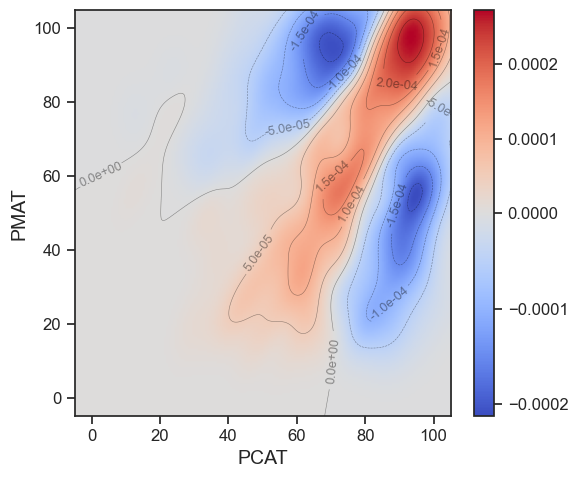

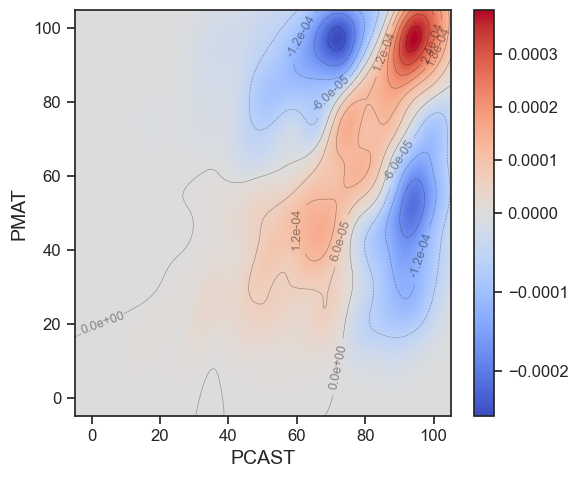

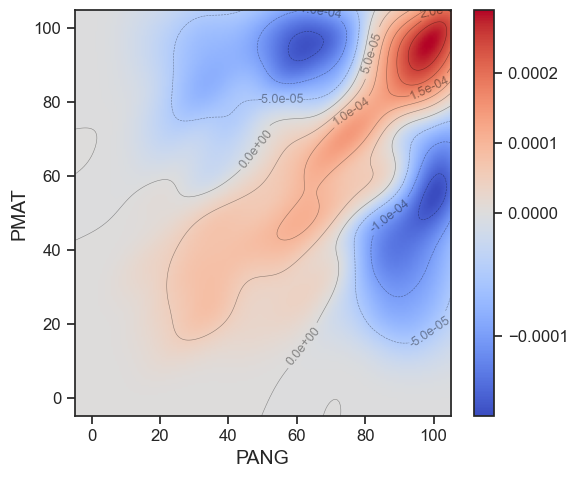

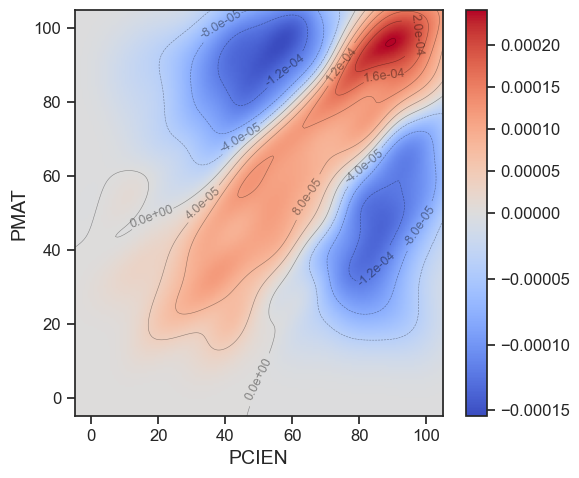

In [31]:
# -------------------- Scatter plots comparision, density difference -------------------

from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import gaussian_kde
import numpy as np
import os

# ---------------- Secondary Original & Shuffled together ----------------------------------
sns.set_theme(style="ticks")

max_points = 1000

# Sample to avoid plotting an enormous dataset
if len(df_S_unique) > max_points:
    df_S_plot = df_S_unique.sample(n=max_points, random_state=0)
else:
    df_S_plot = df_S_unique

# Loop over all subjects except target
for col in other_S:
    # Skip columns that are completely NaN or identical to math column
    if col == math_col_name:
        continue
    if df_S_plot[col].dropna().empty:
        continue

    x = df_S_plot[col].values
    y = df_S_plot[math_col_name].values

    # 1. Convert everything properly
    x = df_S_plot[col].astype(str).str.replace(",", ".", regex=False)
    y = df_S_plot[math_col_name].astype(str).str.replace(",", ".", regex=False)

    # Convert to numeric
    x = pd.to_numeric(x, errors="coerce").to_numpy()
    y = pd.to_numeric(y, errors="coerce").to_numpy()

    # 2. Remove all bad values
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    df_S_clean = df_S_plot.iloc[mask].copy()
    df_S_clean[col] = x
    df_S_clean[math_col_name] = y

    # Suffle all values
    x_shuffled = np.random.permutation(x)
    y_shuffled = np.random.permutation(y)

    # Shuffled data
    df_S_shuffled = df_S_clean.copy()
    df_S_shuffled[col] = x_shuffled
    df_S_shuffled[math_col_name] = y_shuffled

    kde_real = gaussian_kde(np.vstack([x, y]))
    kde_shuffle = gaussian_kde(np.vstack([x_shuffled, y_shuffled]))

    # grid
    X, Y = np.mgrid[0:100:200j, 0:100:200j]
    positions = np.vstack([X.ravel(), Y.ravel()])

    Z_real = kde_real(positions).reshape(X.shape)
    Z_shuf = kde_shuffle(positions).reshape(X.shape)
    Z_diff = Z_real - Z_shuf

    # Create output directory
    os.makedirs("DensityDifferenceHeatmaps", exist_ok=True)

    # KDE grid resolution
    grid_N = 200  

    # Create grid 
    xmin, xmax = 0, 100
    ymin, ymax = 0, 100
    padding = 5                    # extend 5 points beyond boundaries
    X, Y = np.mgrid[
        (xmin-padding):(xmax+padding):complex(grid_N),
        (ymin-padding):(ymax+padding):complex(grid_N)
    ]
    positions = np.vstack([X.ravel(), Y.ravel()])

    # Normalization centered at 0
    norm = TwoSlopeNorm(vcenter=0, vmin=Z_diff.min(), vmax=Z_diff.max())

    # --- PLOT ---
    plt.rcParams.update({
    'font.size': 14,          # mida general
    'axes.titlesize': 16,     # títol
    'axes.labelsize': 14,     # noms dels eixos
    'xtick.labelsize': 12,    # ticks
    'ytick.labelsize': 12,
    'legend.fontsize': 12,    # llegenda
    'font.family': 'Arial'

})

    plt.figure(figsize=(6, 5))

    plt.imshow(
        Z_diff.T,   # transpose for correct orientation
        origin='lower',
        extent=[xmin-padding, xmax+padding, ymin-padding, ymax+padding],
        cmap='coolwarm',
        norm=norm,
        aspect='auto'
    )

    # Contour lines
    ct = plt.contour(
        X, Y, Z_diff,
        levels=10,
        colors='black',
        linewidths=0.4,
        alpha=0.4
    )
    plt.clabel(ct, inline=True, fontsize=9, fmt="%.1e")

    im = plt.imshow(
    Z_diff.T,
    origin='lower',
    cmap='coolwarm',
    norm=norm,
    extent=[xmin-padding, xmax+padding, ymin-padding, ymax+padding],
    aspect='auto'
)
    plt.colorbar(im)

    plt.xlabel(col)
    plt.ylabel(math_col_name)

    #plt.title(f"Density Difference Heatmap: {col} vs {math_col_name}")

    plt.tight_layout()

    # Save figure
    filepath = f"InterSubjects_Correlations_plots/DensityDifferenceHeatmaps"
    os.makedirs(out_dir, exist_ok=True)
    filepath = os.path.join(out_dir, f"{col}_heatmap.png")
    plt.savefig(filepath, dpi=400)
    plt.show()

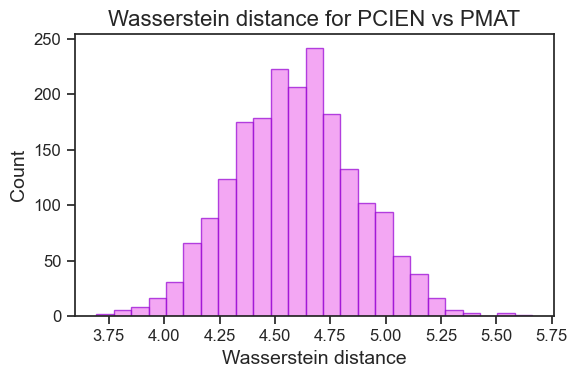

In [32]:
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt

def project_45(x, y):
    # simple projection onto line y = x
    return (x + y) / np.sqrt(2)

def wasser(x, y, n_perm = 1000):

    # 1. Convert everything properly
    x = df_S_plot[col].astype(str).str.replace(",", ".", regex=False)
    y = df_S_plot[math_col_name].astype(str).str.replace(",", ".", regex=False)

    # Convert to numeric
    x = pd.to_numeric(x, errors="coerce").to_numpy()
    y = pd.to_numeric(y, errors="coerce").to_numpy()

    # 2. Remove all bad values
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    df_S_clean = df_S_plot.iloc[mask].copy()
    df_S_clean[col] = x
    df_S_clean[math_col_name] = y

    # 1) observed distance
    z_real = project_45(x, y)

    # 2) null distribution via extra shuffles
    W_null = []

    for _ in range(n_perm):
        y_perm = np.random.permutation(y)      # break dependence
        z_perm = project_45(x, y_perm)
        W_null.append(wasserstein_distance(z_real, z_perm))

    W_null = np.array(W_null)

    return W_null

x = df_S_plot['PCAT'].values
y = df_S_plot['PMAT'].values

W_null = wasser(x, y, n_perm = 2000)

# 3) plot
plt.figure(figsize=(6,4))
plt.hist(W_null, bins=25, alpha=0.7, color="violet", edgecolor="darkviolet")
plt.xlabel("Wasserstein distance")
plt.ylabel("Count")
plt.title(f"Wasserstein distance for {col} vs {math_col_name}")
#plt.legend()
plt.tight_layout()
plt.show()

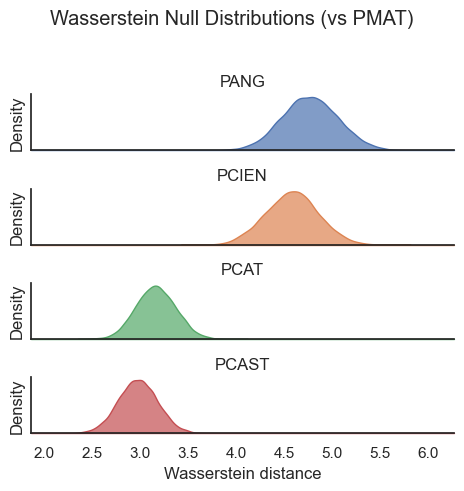

In [33]:
# --- collect Wasserstein null distributions ---
W_dists = {}    # subject → list of W values

for col in other_S:
    if col == math_col_name:
        continue
    
    # Call YOUR function
    Ws = wasser(df_S_plot[col], df_S_plot[math_col_name], n_perm=10000)
    
    if len(Ws) > 0:
        W_dists[col] = Ws

# --- Convert to long dataframe for plotting ---
rows = []
for subj, Ws in W_dists.items():
    for w in Ws:
        rows.append({"subject": subj, "W": w})

W_long = pd.DataFrame(rows)

# Sort subjects by mean W (strongest dependence first)
mean_scores = W_long.groupby("subject")["W"].mean().sort_values(ascending=False)
ordered_subjects = mean_scores.index.tolist()

W_long["subject"] = pd.Categorical(W_long["subject"], 
                                   categories=ordered_subjects, 
                                   ordered=True)

# --- Ridgeline plot ---
sns.set_theme(style="white")

g = sns.FacetGrid(
    W_long,
    row="subject",
    hue="subject",
    aspect=4,
    height=1.2,
    sharex=True,
    sharey=False
)

g.map(sns.kdeplot, "W", fill=True, alpha=0.7)
g.map(plt.axhline, y=0, lw=1, clip_on=False)

g.set_titles(row_template="{row_name}")
g.set_xlabels("Wasserstein distance")
g.set_ylabels("Density")

# Make ridgeline cleaner
for ax in g.axes.flatten():
    ax.set_yticks([])

plt.suptitle(f"Wasserstein Null Distributions (vs {math_col_name})", y=1.02)
plt.tight_layout()
plt.show()

In [34]:
from scipy.stats import wasserstein_distance
import numpy as np
import pandas as pd

def project_45(x, y):
    return (x + y) / np.sqrt(2)

def wasser(x_raw, y_raw, n_perm=500):
    # 1. Clean conversion
    x = x_raw.astype(str).str.replace(",", ".", regex=False)
    y = y_raw.astype(str).str.replace(",", ".", regex=False)

    x = pd.to_numeric(x, errors="coerce").to_numpy()
    y = pd.to_numeric(y, errors="coerce").to_numpy()

    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]

    # Observed statistic = mean W between real (x,y) and many shuffled y
    z_real = project_45(x, y)

    W_obs_list = []
    for _ in range(n_perm):
        y_perm = np.random.permutation(y)
        z_perm = project_45(x, y_perm)
        W_obs_list.append(wasserstein_distance(z_real, z_perm))

    W_obs = np.mean(W_obs_list)

    # Null distribution: distances under full independence
    W_null = []
    for _ in range(n_perm):
        y_perm1 = np.random.permutation(y)
        y_perm2 = np.random.permutation(y)

        z1 = project_45(x, y_perm1)
        z2 = project_45(x, y_perm2)

        W_null.append(wasserstein_distance(z1, z2))

    return W_obs, np.array(W_null)

p_values = {}
W_observed_values = {}

print('Null values for W')
for col in other_S:
    if col == math_col_name:
        continue

    W_obs, W_null = wasser(df_S_plot[col], df_S_plot[math_col_name], n_perm=2000)
    print(np.mean(W_null))

    # p-value formula:
    p = np.mean(W_null >= W_obs)

    p_values[col] = p
    W_observed_values[col] = W_obs

results_df = pd.DataFrame({
    "W_obs": W_observed_values,
    "p_value": p_values
}).sort_values("W_obs", ascending=False)

print(results_df)

Null values for W
0.5811055039360865
0.5816699095956241
0.725999295193251
0.7107316942671073
          W_obs  p_value
PANG   4.762586      0.0
PCIEN  4.582979      0.0
PCAT   3.163604      0.0
PCAST  2.979966      0.0


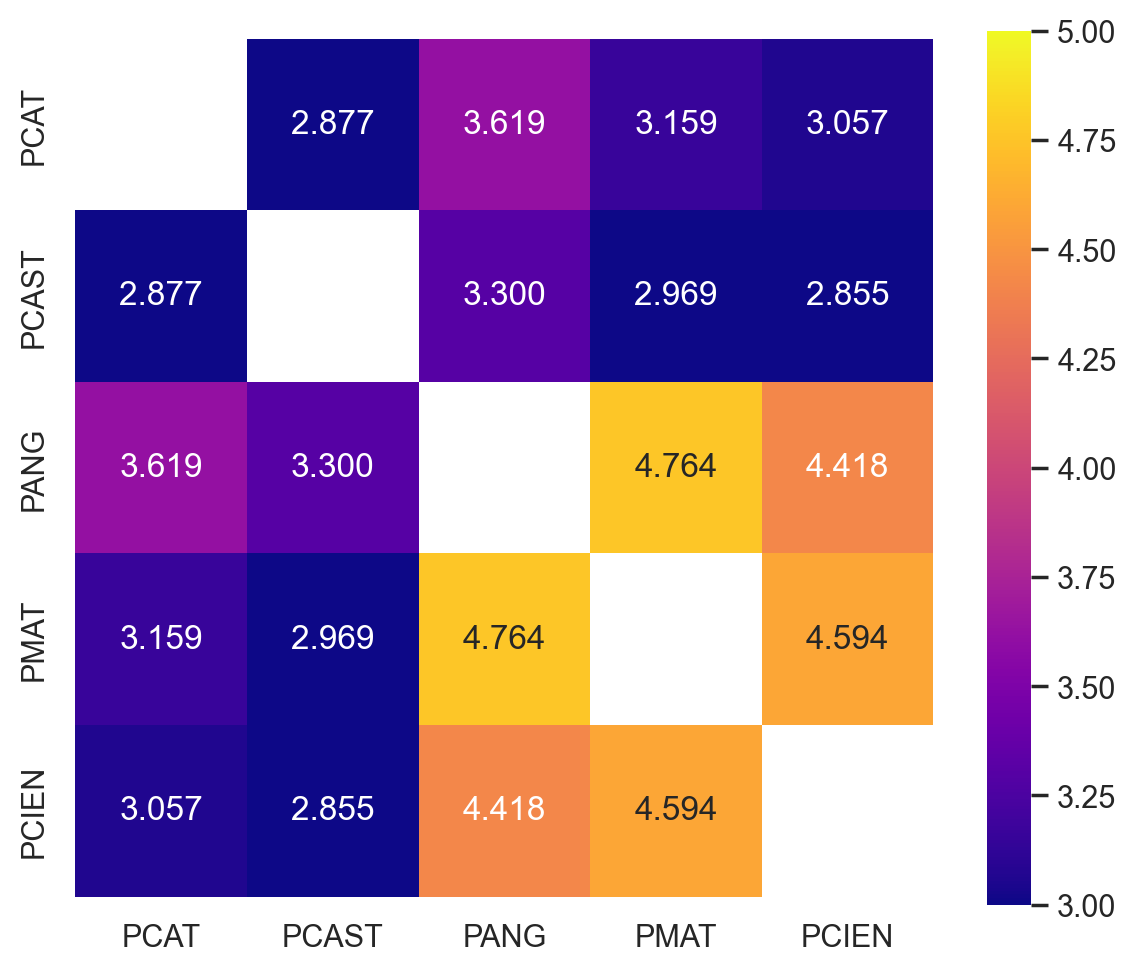

In [35]:
from scipy.stats import wasserstein_distance

plt.rcParams.update({
    'font.size': 14,          # mida general
    'axes.titlesize': 16,     # títol
    'axes.labelsize': 14,     # noms dels eixos
    'xtick.labelsize': 12,    # ticks
    'ytick.labelsize': 12,
    'legend.fontsize': 12,    # llegenda
})

def project_45(x, y):
    """Project (x, y) onto the line y = x."""
    return (x + y) / np.sqrt(2)

def wasser_correct(x_raw, y_raw, n_perm=200):
    """
    Compute observed Wasserstein dependence between two subjects:
    - Clean numeric data
    - Project onto 45º
    - W_obs = mean distance between real projection and many shuffled copies
    (W_null aquí no el farem servir per la matriu, només retornem W_obs)
    """
    # Convert to numeric with dot decimals
    x = x_raw.astype(str).str.replace(",", ".", regex=False)
    y = y_raw.astype(str).str.replace(",", ".", regex=False)

    x = pd.to_numeric(x, errors="coerce").to_numpy()
    y = pd.to_numeric(y, errors="coerce").to_numpy()

    # Remove NaNs
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]

    if len(x) < 20:
        return np.nan  # not enough data

    z_real = project_45(x, y)

    # Observed: average distance between real and many shuffled copies
    W_obs_list = []
    for _ in range(n_perm):
        y_perm = np.random.permutation(y)
        z_perm = project_45(x, y_perm)
        W_obs_list.append(wasserstein_distance(z_real, z_perm))

    W_obs = float(np.mean(W_obs_list))
    return W_obs

import seaborn as sns
import matplotlib.pyplot as plt

# Subject List
grade_cols_S = ['PCAT', 'PCAST', 'PANG', 'PMAT', 'PCIEN']

# Initialize empty distance matrix
W_matrix = pd.DataFrame(
    np.nan,
    index=grade_cols_S,
    columns=grade_cols_S,
    dtype=float
)

# Fill upper triangle and mirror to lower triangle
for i, col_i in enumerate(grade_cols_S):
    for j, col_j in enumerate(grade_cols_S):
        if j < i:
            continue  # we will mirror later
        if col_i == col_j:
            W_matrix.loc[col_i, col_j] = 0.0  # distance with itself
        else:
            W_ij = wasser_correct(df_S_plot[col_i], df_S_plot[col_j], n_perm=2000)
            W_matrix.loc[col_i, col_j] = W_ij
            W_matrix.loc[col_j, col_i] = W_ij  # symmetric

plt.rcParams.update({
'font.size': 14,          # mida general
'axes.titlesize': 16,     # títol
'axes.labelsize': 14,     # noms dels eixos
'xtick.labelsize': 12,    # ticks
'ytick.labelsize': 12,
'legend.fontsize': 12,    # llegenda
'font.family': 'Arial'

})

plt.figure(figsize=(6, 5), dpi = 200)
sns.set_theme(style="white")

# Mask diagonal
mask = np.zeros_like(W_matrix, dtype=bool)
np.fill_diagonal(mask, True)

sns.heatmap(
    W_matrix,
    mask=mask,
    cmap="plasma",
    annot=True,        
    fmt=".3f",
    square=True,
    cbar_kws={},
    vmin = 3,
    vmax = 5
)

plt.tight_layout()
plt.savefig('WasserDistMatrixSec', dpi = 500)
plt.show()

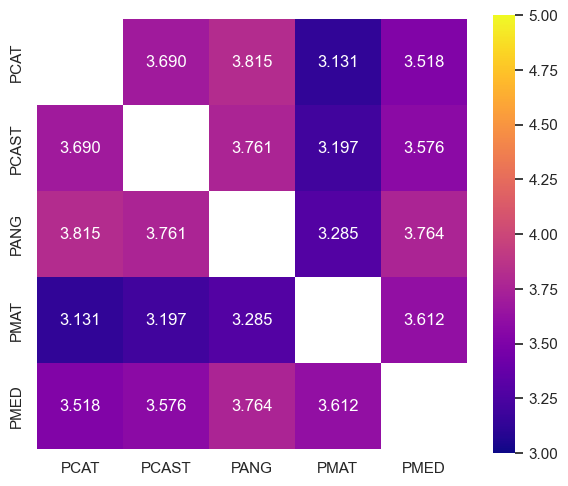

In [36]:
from scipy.stats import wasserstein_distance
import numpy as np
import pandas as pd

max_points = 10000000

if len(df_P_unique) > max_points:
    df_P_plot = df_P_unique.sample(n=max_points, random_state=0)
else:
    df_P_plot = df_P_unique

def project_45(x, y):
    """Project (x, y) onto the line y = x."""
    return (x + y) / np.sqrt(2)

def wasser_correct(x_raw, y_raw, n_perm=200):
    """
    Compute observed Wasserstein dependence between two subjects:
    - Clean numeric data
    - Project onto 45º
    - W_obs = mean distance between real projection and many shuffled copies
    """
    # Convert to numeric with dot decimals
    x = x_raw.astype(str).str.replace(",", ".", regex=False)
    y = y_raw.astype(str).str.replace(",", ".", regex=False)

    x = pd.to_numeric(x, errors="coerce").to_numpy()
    y = pd.to_numeric(y, errors="coerce").to_numpy()

    # Remove NaNs
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]

    if len(x) < 20:
        return np.nan  # not enough data

    z_real = project_45(x, y)

    # Observed: average distance between real and many shuffled copies
    W_obs_list = []
    for _ in range(n_perm):
        y_perm = np.random.permutation(y)
        z_perm = project_45(x, y_perm)
        W_obs_list.append(wasserstein_distance(z_real, z_perm))

    W_obs = float(np.mean(W_obs_list))
    return W_obs

import seaborn as sns
import matplotlib.pyplot as plt

# Subject list
grade_cols_P = ['PCAT', 'PCAST', 'PANG', 'PMAT', 'PMED']

# Initialize empty distance matrix
W_matrix = pd.DataFrame(
    np.nan,
    index=grade_cols_P,
    columns=grade_cols_P,
    dtype=float
)

# Fill upper triangle and mirror to lower triangle
for i, col_i in enumerate(grade_cols_P):
    for j, col_j in enumerate(grade_cols_P):
        if j < i:
            continue  # we will mirror later
        if col_i == col_j:
            W_matrix.loc[col_i, col_j] = 0.0  # distance with itself
        else:
            W_ij = wasser_correct(df_P_plot[col_i], df_P_plot[col_j], n_perm=500)
            W_matrix.loc[col_i, col_j] = W_ij
            W_matrix.loc[col_j, col_i] = W_ij  # symmetric

plt.rcParams.update({
'font.size': 14,          # mida general
'axes.titlesize': 16,     # títol
'axes.labelsize': 14,     # noms dels eixos
'xtick.labelsize': 12,    # ticks
'ytick.labelsize': 12,
'legend.fontsize': 12,    # llegenda
'font.family': 'Arial'

})

plt.figure(figsize=(6, 5))
sns.set_theme(style="white")

# Mask diagonal (no es rellevant)
mask = np.zeros_like(W_matrix, dtype=bool)
np.fill_diagonal(mask, True)

sns.heatmap(
    W_matrix,
    mask=mask,
    cmap="plasma",
    annot=True,         
    fmt=".3f",
    square=True,
    cbar_kws={},
    vmin = 3,
    vmax = 5
)

plt.tight_layout()
plt.savefig('WasserDistMatrixPrim', dpi = 400)
plt.show()

In [37]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance

def to_float_series(s):
    s = s.astype(str).str.replace(",", ".", regex=False)
    return pd.to_numeric(s, errors="coerce")

def project_45(x, y):
    return (x + y) / np.sqrt(2)

def wasserstein_null_distribution(x_raw, y_raw, K=100, random_state=None):
    """
    For one subject vs maths, return a list of Wasserstein distances
    between the real projected data and K shuffled versions.
    """
    rng = np.random.default_rng(random_state)

    x = to_float_series(x_raw).to_numpy()
    y = to_float_series(y_raw).to_numpy()
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]

    if len(x) < 20:
        return []

    z_real = project_45(x, y)

    Ws = []
    for _ in range(K):
        y_perm = rng.permutation(y)
        z_perm = project_45(x, y_perm)
        Ws.append(wasserstein_distance(z_real, z_perm))

    return Ws

# --------- compute for all subjects ---------

K = 100  # number of shuffles per subject

W_dists = {}   # subject -> list of W's
W_means = {}   # subject -> mean W

for col in other_S:
    if col == math_col_name:
        continue

    Ws = wasserstein_null_distribution(df_S_plot[col], df_S_plot[math_col_name],
                                       K=K, random_state=0)
    if len(Ws) == 0:
        continue

    W_dists[col] = Ws
    W_means[col] = float(np.mean(Ws))

W_mean_series = pd.Series(W_means).sort_values(ascending=False)

# Private vs Public (Bonus)

<Figure size 3840x2880 with 0 Axes>

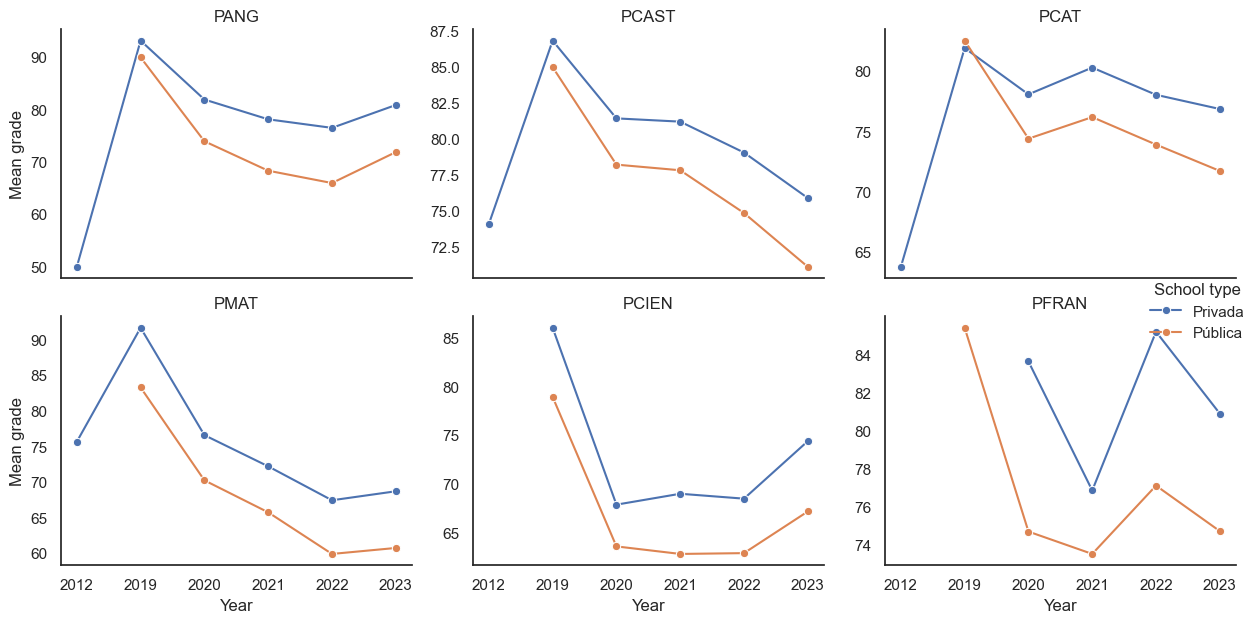

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# -------------------------------------------------
# 1. CONFIGURING NAMES TO MATCH THE DATA
# -------------------------------------------------

df = df_S_unique  

# Column that indicates school type (public/private)
school_type_col = "NATURALESA" 

# Column that indicates year
year_col = "ANY"          

# Subjects in secondary
grade_cols = ['PCAT', 'PCAST', 'PMAT', 'PANG', 'PFRAN', 'PCIEN']

# -------------------------------------------------
# 2. Ensure grades are numeric and keep only needed columns
# -------------------------------------------------

# Work on a copy to avoid modifying original
df_plot = df.copy()

# Convert chosen grade columns to numeric
for col in grade_cols:
    if col in df_plot.columns:
        s = df_plot[col].astype(str).str.replace(",", ".", regex=False)
        df_plot[col] = pd.to_numeric(s, errors="coerce")
    else:
        print(f"Warning: column {col} not found in DataFrame.")

# Drop rows where school type or year is missing
df_plot = df_plot.dropna(subset=[school_type_col, year_col])

# -------------------------------------------------
# 3. Reshape to long format: one row per (student, subject)
# -------------------------------------------------

# Keep only existing subject columns
existing_grade_cols = [c for c in grade_cols if c in df_plot.columns]

long_df = df_plot[[school_type_col, year_col] + existing_grade_cols].melt(
    id_vars=[school_type_col, year_col],
    value_vars=existing_grade_cols,
    var_name="subject",
    value_name="grade"
)

# Remove rows with missing grades
long_df = long_df.dropna(subset=["grade"])

# -------------------------------------------------
# 4. Compute mean grades by (school type, year, subject)
# -------------------------------------------------

mean_df = (
    long_df
    .groupby([school_type_col, year_col, "subject"], as_index=False)["grade"]
    .mean()
)

# If year is numeric, sort by it
if pd.api.types.is_numeric_dtype(mean_df[year_col]):
    mean_df = mean_df.sort_values(year_col)

# -------------------------------------------------
# 5. Plot: one facet per subject, lines for public vs private
# -------------------------------------------------
plt.figure(dpi=600)

g = sns.FacetGrid(
    mean_df,
    col="subject",
    hue=school_type_col,
    col_wrap=3,
    sharey=False,
    height=3.2,
    aspect=1.2
)

g.map_dataframe(
    sns.lineplot,
    x=year_col,
    y="grade",
    marker="o"
)

label_map = {
    "PÃºblica": "Pública",
    "Privada": "Privada"
}

g.add_legend(title="School type")

legend = g._legend
for text in legend.texts:
    text.set_text(label_map.get(text.get_text(), text.get_text()))

g.set_axis_labels("Year", "Mean grade")
g.set_titles("{col_name}")

plt.tight_layout()
plt.show()

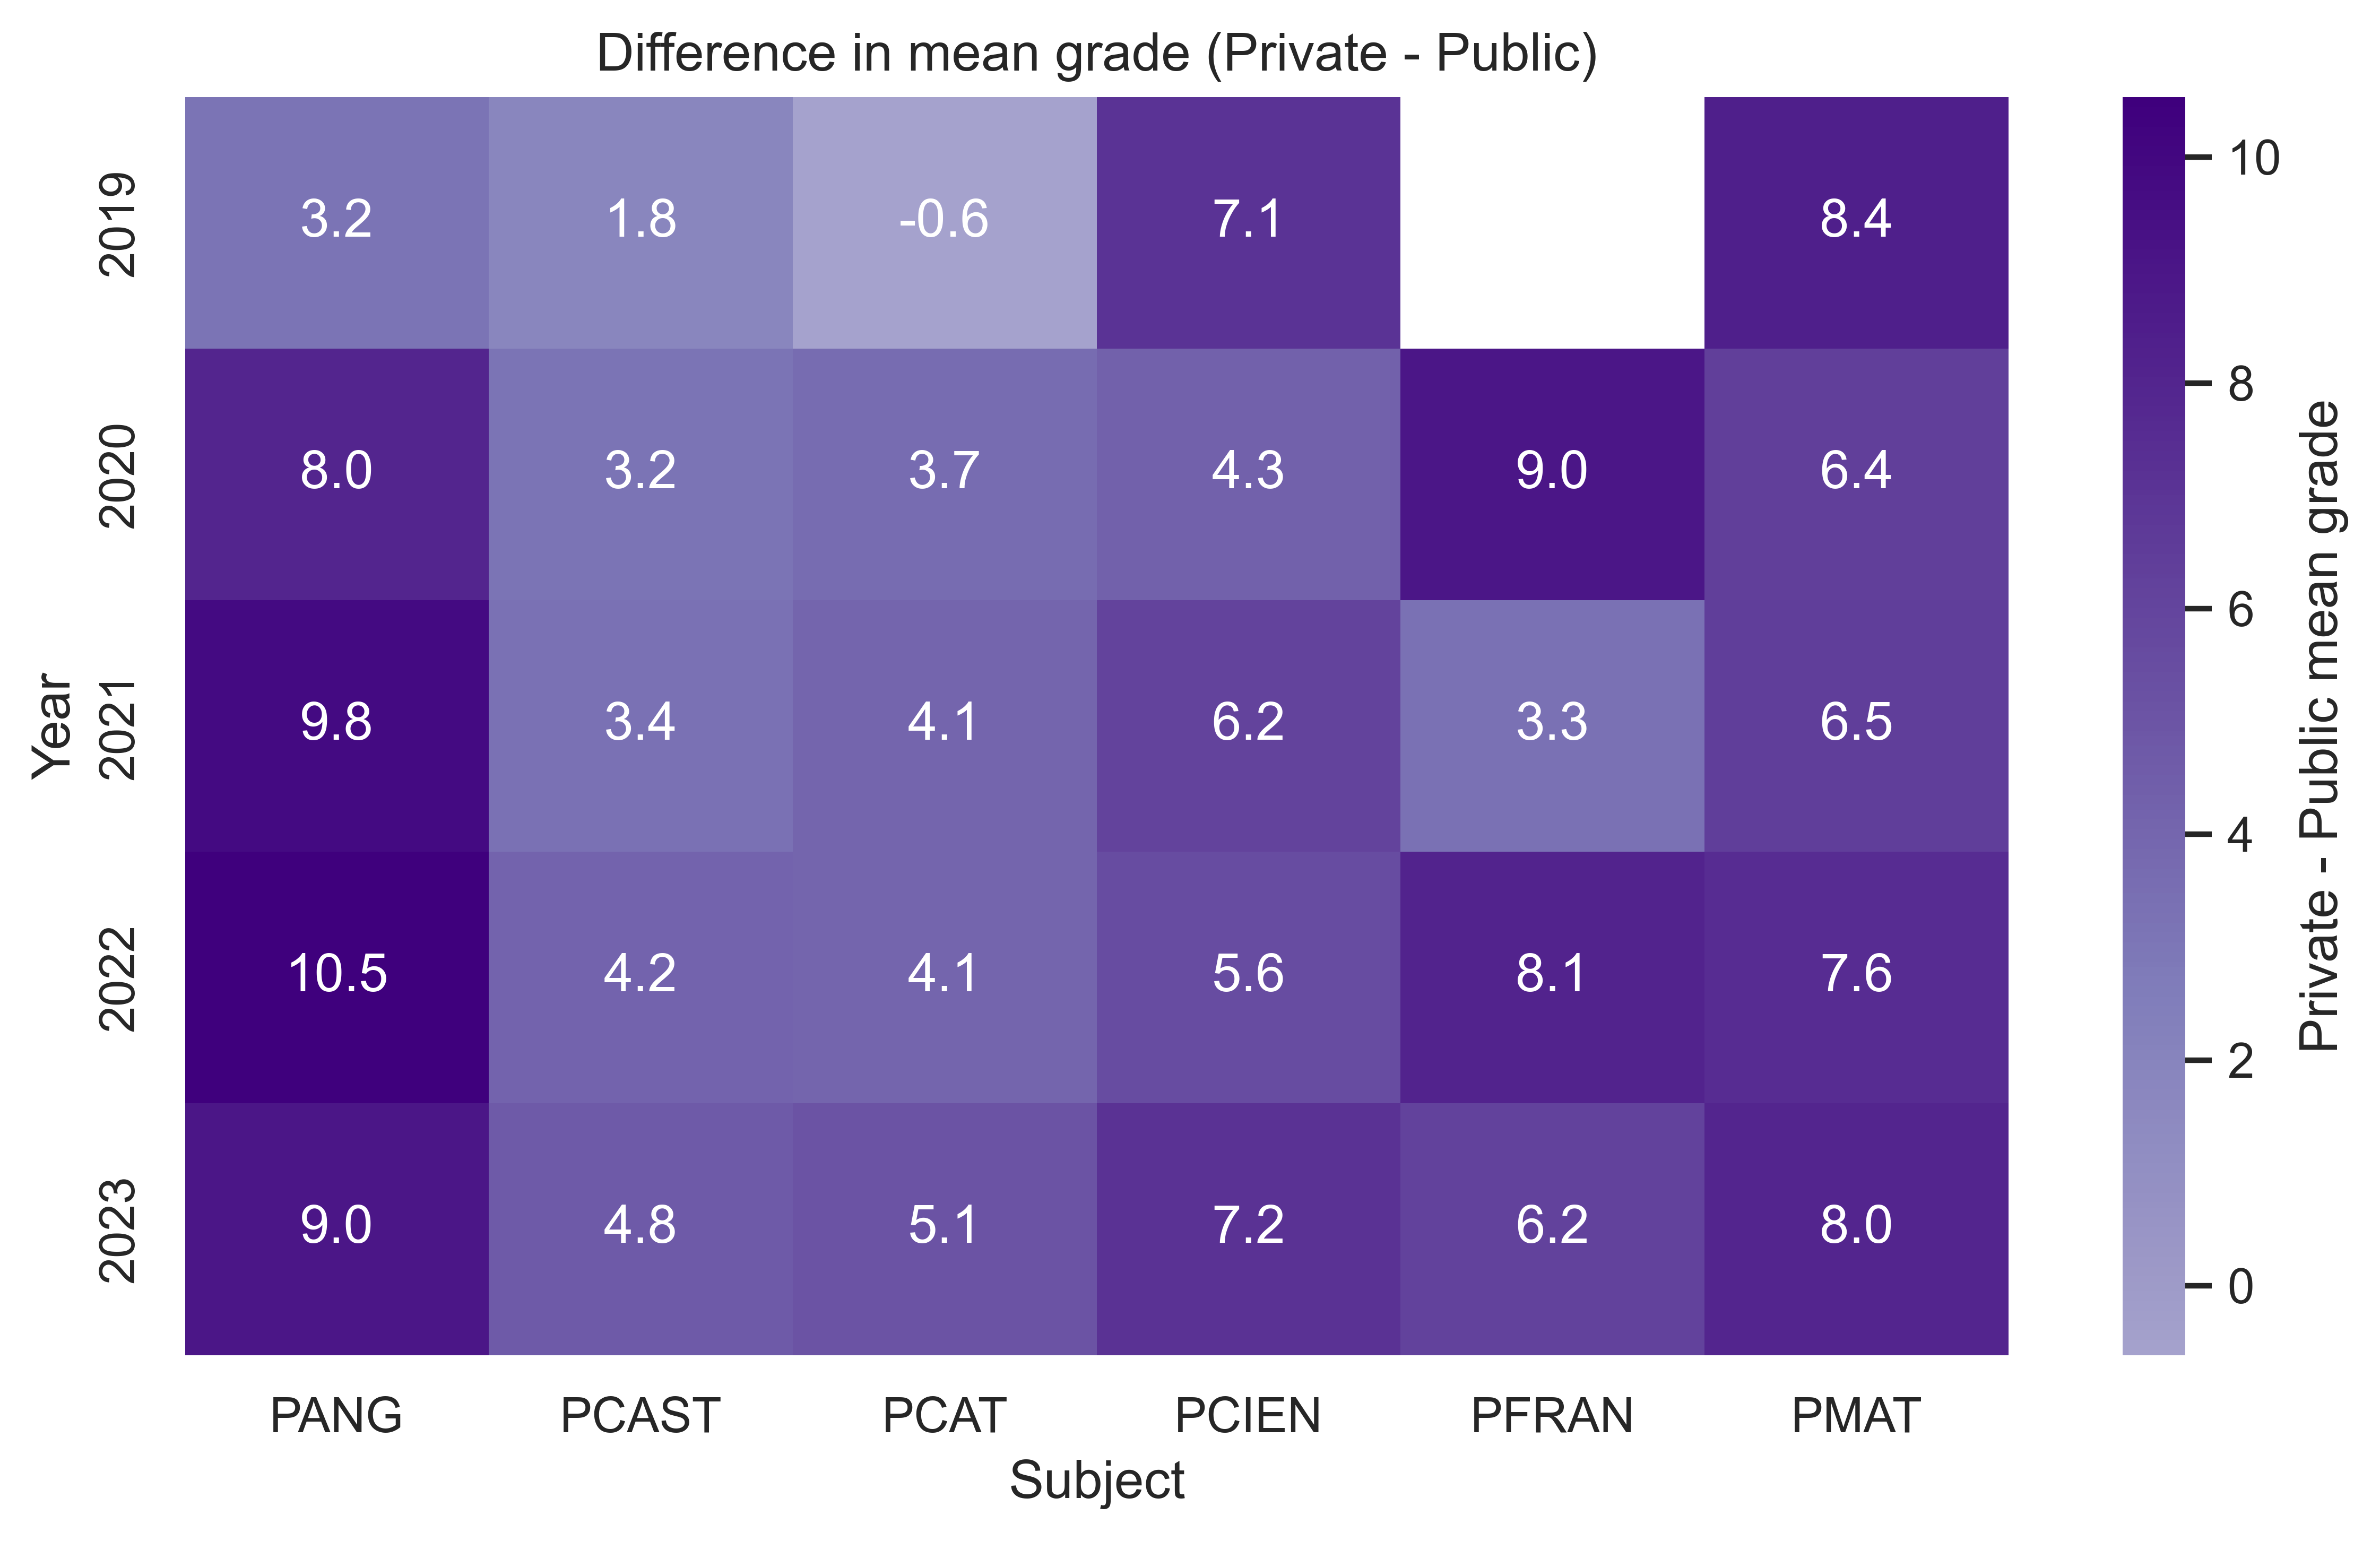

In [39]:
sns.set_theme(style="white")

public_label  = "PÃºblica"
private_label = "Privada"

# Filter for each school type
df_public  = mean_df[mean_df[school_type_col] == public_label]
df_private = mean_df[mean_df[school_type_col] == private_label]

# -------------------------------------------------
# 2. Merge public & private on (year, subject)
# -------------------------------------------------
merged = pd.merge(
    df_private,
    df_public,
    on=[year_col, "subject"],
    suffixes=("_priv", "_pub"),
    how="inner"   # only keep combos where we have both types
)

# Compute difference: Private – Public
merged["diff"] = merged["grade_priv"] - merged["grade_pub"]

# -------------------------------------------------
# 3. Pivot to matrix: rows = years, columns = subjects
# -------------------------------------------------
pivot_diff = merged.pivot(
    index=year_col,
    columns="subject",
    values="diff"
)

# -------------------------------------------------
# 4. Plot heatmap (diverging colormap centered at 0)
# -------------------------------------------------
plt.figure(figsize=(8, 5), dpi = 600)

ax = sns.heatmap(
    pivot_diff,
    cmap='Purples',   
    center=0,          # 0 = same mean grade
    annot=True,
    fmt=".1f",
    cbar_kws={"label": "Private - Public mean grade"}
)

ax.set_title("Difference in mean grade (Private - Public)")
ax.set_ylabel("Year")
ax.set_xlabel("Subject")

plt.tight_layout()
plt.show()